In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

valset, testset = torch.utils.data.random_split(testset, [int(len(testset)*0.9), int(len(testset)*0.1)])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 509kB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.43MB/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [3]:
 train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
 val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)
 test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [4]:
class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.linear_1 = torch.nn.Linear(in_features=64*7*7, out_features=128)
    self.linear_2 = torch.nn.Linear(in_features=128, out_features=84)
    self.linear_3 = torch.nn.Linear(in_features=84, out_features=10)
    self.dropout = torch.nn.Dropout(p=0.5)
    self.relu = torch.nn.ReLU()


  def forward(self, x):
    x = self.conv_1(x)
    x = self.relu(x)
    x = self.max_pool2d(x)
    x = self.conv_2(x)
    x = self.relu(x)
    x = self.max_pool2d(x)
    x = x.view(-1, 64*7*7)
    x = self.linear_1(x)
    x = self.relu(x)
    x = self.linear_2(x)
    x = self.relu(x)
    x = self.dropout(x)
    pred = self.linear_3(x)

    return pred

In [5]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
if torch.cuda.is_available():
  model = model.cuda()

num_epoch = 10
train_loss = []
val_loss = []
best_val_loss = 1

In [7]:
for epoch in range(num_epoch):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    for itr, (image, label) in enumerate(train_loader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_loader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, num_epoch, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")



Epoch: 1/10, Train Loss: 0.28843904, Val Loss: 0.05520694, Val Accuracy: 0.98144444
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.05520694

Epoch: 2/10, Train Loss: 0.07890605, Val Loss: 0.03645646, Val Accuracy: 0.98811111
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03645646

Epoch: 3/10, Train Loss: 0.05581827, Val Loss: 0.04031811, Val Accuracy: 0.98733333

Epoch: 4/10, Train Loss: 0.04204955, Val Loss: 0.03671615, Val Accuracy: 0.98877778

Epoch: 5/10, Train Loss: 0.03297380, Val Loss: 0.03534547, Val Accuracy: 0.98955556
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.03534547

Epoch: 6/10, Train Loss: 0.02748102, Val Loss: 0.03248025, Val Accuracy: 0.99100000
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.03248025

Epoch: 7/10, Train Loss: 0.02261742, Val Loss: 0.03460260, Val Accuracy: 0.98977778

Epoch: 8/10, Train Loss: 0.01872451, Val Loss: 0.03915516, Val Accuracy: 0.99055556


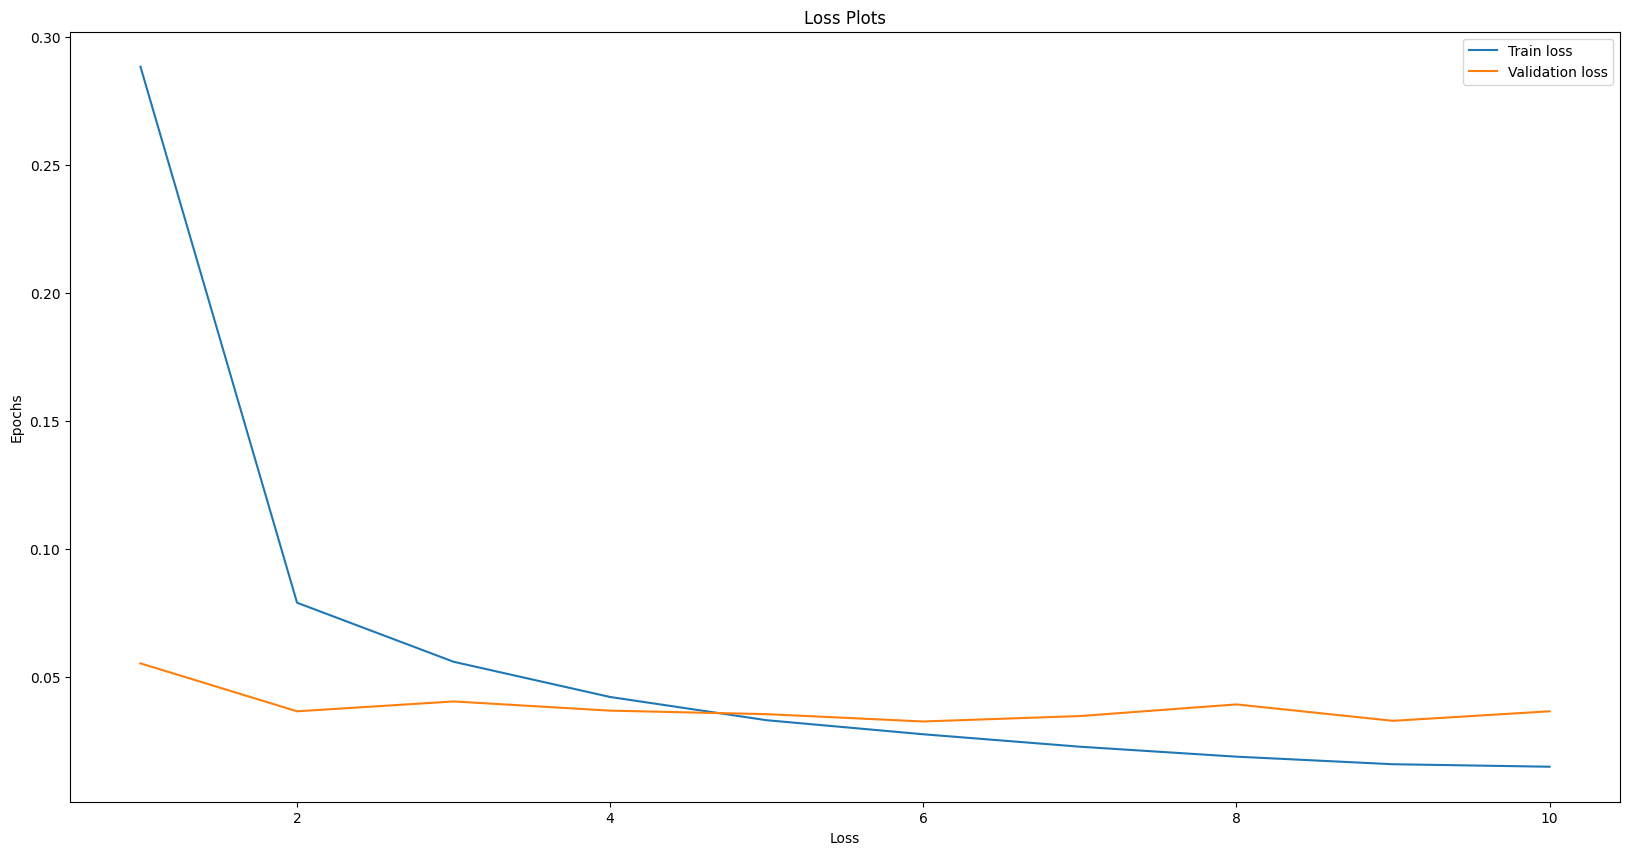

In [8]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label="Train loss")
plt.plot(np.arange(1, len(val_loss)+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

<ipython-input-14-ac35116c64da>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.dth"))


0.989


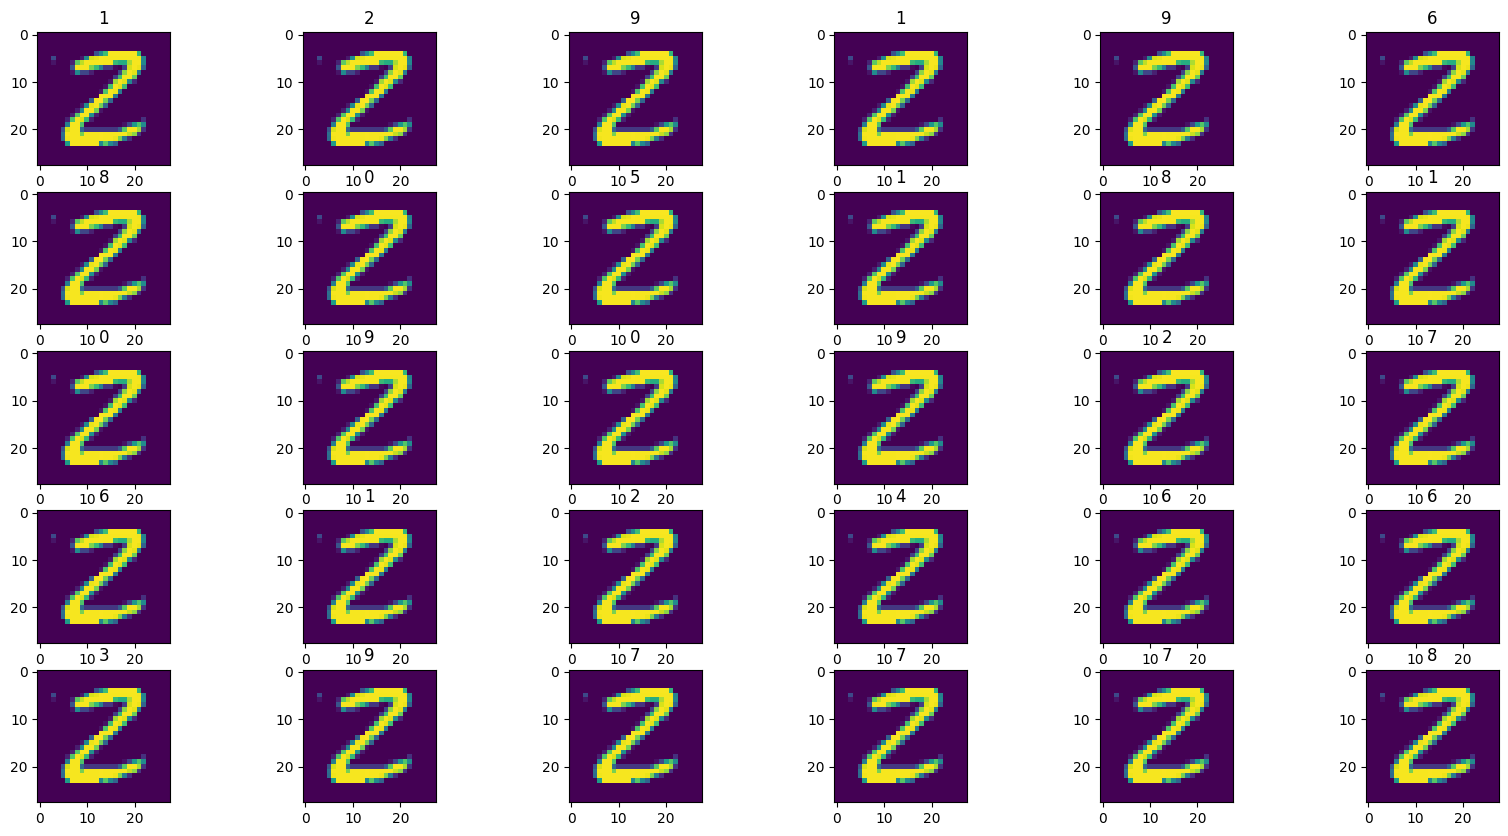

In [14]:
model.load_state_dict(torch.load("model.dth"))
model.eval()

results = list()
total = 0
total_samples = 0
for itr, (image, label) in enumerate(test_loader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        total_samples += 1
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / total_samples
print(test_accuracy)

# visualize results
fig=plt.figure(figsize=(20, 10))
for i in range(1, 31):
    # Convert the image tensor to the correct format
    img_tensor = results[i][0].detach().cpu()
    # If the image has more than 3 dimensions, select the appropriate channels/slices
    if img_tensor.dim() > 3:
        # Assuming the image is in the format (C, H, W) or (N, C, H, W)
        img_tensor = img_tensor[0]  # Select the first channel/image if multiple are present
    # If the image has 3 dimensions and mode is 'L', convert to grayscale
    mode = 'L'
    if img_tensor.dim() == 3 and mode == 'L':
        img_tensor = img_tensor.mean(0)  # Average across channels to get grayscale

    img = transforms.ToPILImage(mode='L')(img_tensor)
    fig.add_subplot(5, 6, i)
    plt.title(results[i][1].item())
    plt.imshow(img)
plt.show()